In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import analysis.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)



Qubit(ro_dur=4000, ro_freq=6.7275, ef_time=76.33212714344363, ef_ssm=-0.255, qubit_thr=[-10000, -600], ef_amp=1, ge_amp=1.2, ROIF=0.10280000000000022, IQ_angle=205, RO_LO=6.6247, ge_time=51.07894601677215, RO_LO_pwr=16, ge_ssm=-0.11, ro_amp=0.6, ROq3=6.583064, qubit_id=q1)
Qubit(ro_dur=4000, ro_freq=6.65555, ef_time=None, ef_ssm=-0.224, qubit_thr=[-10000, 2500], ef_amp=1, ge_amp=1.2, ROIF=0.030850000000000044, IQ_angle=85, RO_LO=6.6247, ge_time=40.15374412400174, RO_LO_pwr=16, ge_ssm=-0.152, ro_amp=0.4, ROq3=6.583064, qubit_id=q2)


In [4]:
def run_rabi_ef_swap(q1: object, q2: object, general_vals_dict: dict,
                     num_steps: int, sweep_time: float,
                     swap_freq: float, swap_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]
    
    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    
    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified['predicted']
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    
    # Initialize arrays to hold the probabilities vs. time.
    P_f_time = np.zeros(num_steps)
    P_e_time = np.zeros(num_steps)
    P_g_time = np.zeros(num_steps)
    
    # For each time step, calculate the probabilities.
    for time_index, step_data in enumerate(states_reshaped):
        # step_data is (typically) a list/array of state measurements at this time step.
        prob_dict = classifier.probabilities(step_data)
        P_f_time[time_index] = prob_dict['P_f']
        P_e_time[time_index] = prob_dict['P_e']
        P_g_time[time_index] = prob_dict['P_g']
    
    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time/1000, num_steps)
    
    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame({
        'P_f': P_f_time,
        'P_e': P_e_time,
        'P_g': P_g_time
    }, index=times)
    
    return df_prob, states, values


def ef_freq_sweep(freq_start: float, freq_stop: float, freq_steps: int,
                  q1: object, q2: object, general_vals_dict: dict,
                  num_steps: int, sweep_time: float,
                  swap_freq: float, swap_time: float, reps: int):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a 
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.
    
    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as 
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Create an array of frequency values
    frequencies = np.linspace(freq_start, freq_stop, freq_steps)
    
    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    probability_dataframes = {freq: None for freq in frequencies}
    
    # Loop over frequencies and populate the dictionary
    for freq in frequencies:
        q1.ef_ssm = freq  # Set the instrument's frequency
        # Run the experiment and get the probability vs. time DataFrame
        df_prob = run_rabi_ef_swap(q1, q2, general_vals_dict, num_steps,
                                   sweep_time, swap_freq, swap_time, reps)
        # Populate the dictionary at the corresponding frequency key
        probability_dataframes[freq] = df_prob
    
    return probability_dataframes


# max_index_P_f = np.unravel_index(np.argmax(P_f),P_f.shape)

# freq_P_renorm_f=max_index_P_f[0]
# P_renorm_f_rf=P_f[freq_P_renorm_f]
# P_renorm_e_rf=P_e[freq_P_renorm_f]


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 500
Buffers per acquistion: 9
DAQ samples per pattern: 8192
0, No error
Capturing 9 buffers. Press <enter> to abort
Capture completed in 3.679061 sec
Captured 9 buffers (2.446276 buffers per sec)
Captured 27648 records (7514.961149 records per sec)
Transferred 452984832 bytes (123125123.471232 bytes per sec)


<Figure size 800x800 with 0 Axes>

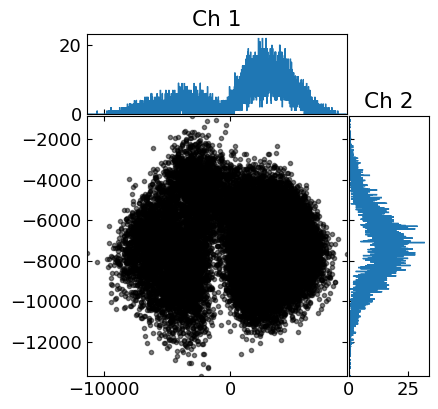

<Figure size 800x800 with 0 Axes>

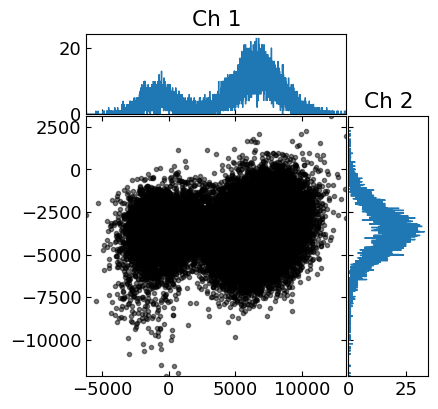

In [12]:
num_steps = 51
reps = 500
sweep_time = 1000
freq_start=-0.252
freq_stop=-0.254
freq_steps= 3
swap_freq=-.021
swap_time=213.58765318403013
check_df, states, values = run_rabi_ef_swap(q1, q2, general_vals_dict,
                     num_steps, sweep_time,
                     swap_freq, swap_time, reps)

51

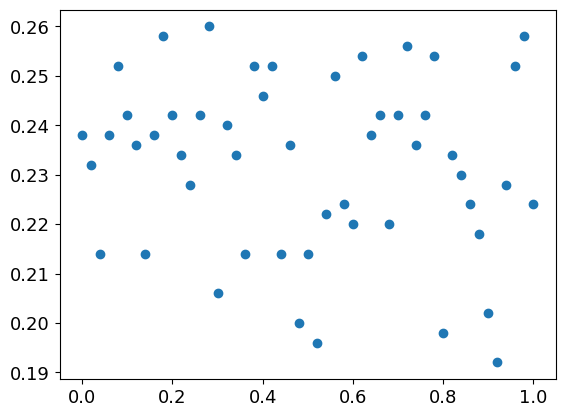

In [34]:
I1 = values.rec_avg_vs_pats_1[0]
Q1 = values.rec_avg_vs_pats_1[1]
I2 = values.rec_avg_vs_pats_2[0]
Q2 = values.rec_avg_vs_pats_2[1]
IQ_df = pd.DataFrame({
        "I1": I1,
        "Q1": Q1,
        "I2": I2,
        "Q2": Q2
    })

plt.figure()
#plt.scatter([i for i in range(len(states))],states)
plt.scatter(check_df.index, check_df['P_e'])
#plt.plot(check_df.index, I1)
len(IQ_df)

In [33]:
# Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
#IQ_df.columns
#classified = classifier.classify(IQ_df)
states = classified['predicted']
states


0     1
1     1
2     0
3     2
4     2
5     2
6     0
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
Name: predicted, dtype: int64

In [ ]:
P_renorm_e[i] = P_eml[i]/(P_fml[i] + P_eml[i])
P_renorm_f[i] = P_fml[i]/(P_fml[i] + P_eml[i])

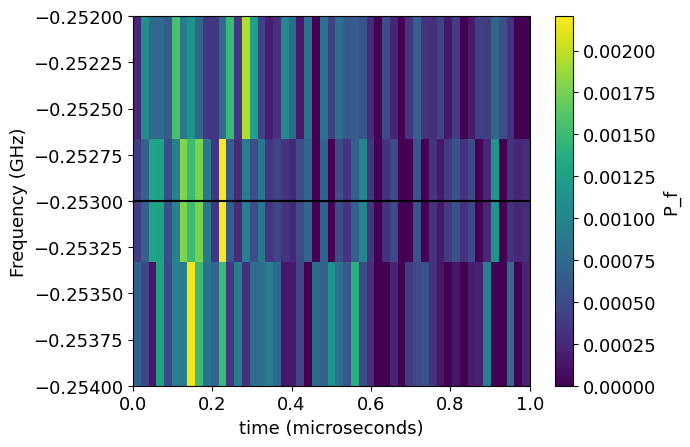

rf= -0.253


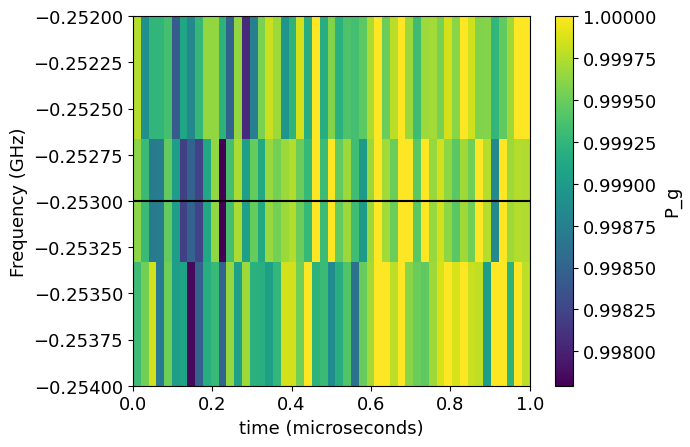

rf= -0.253
RuntimeError


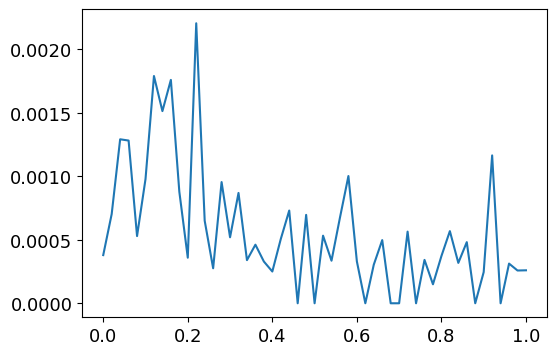



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
Angular freq(rad/$\mu$ s): nan


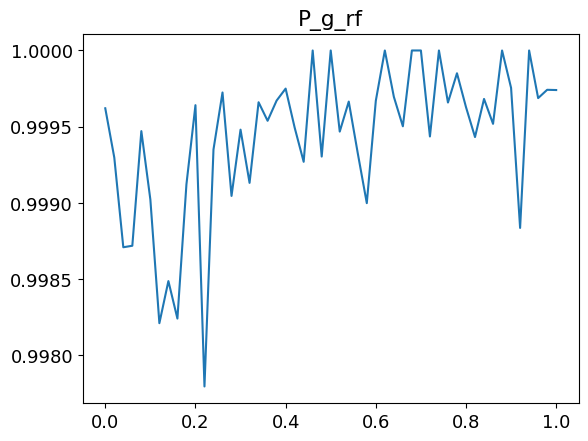

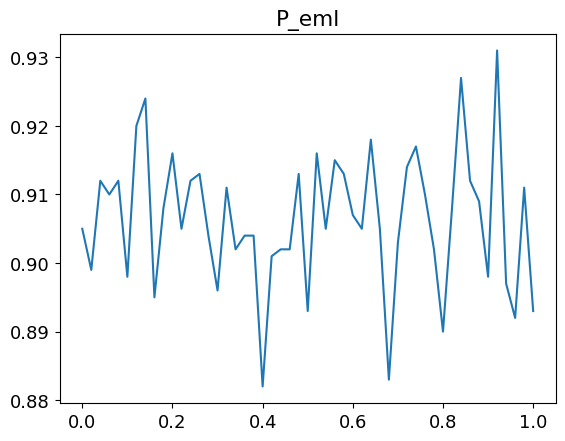

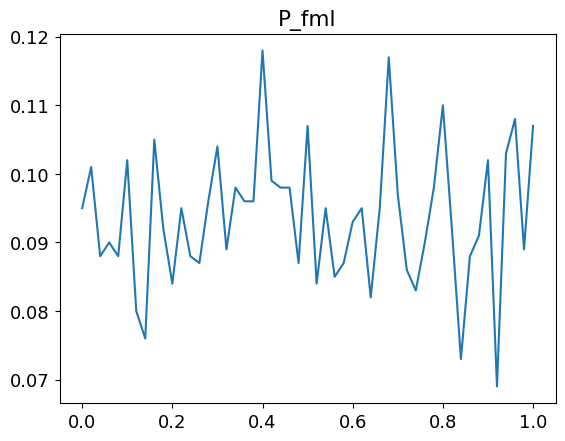

In [ ]:
max_index_P_f = np.unravel_index(np.argmax(P_f),P_f.shape)
min_index_P_ge = np.unravel_index(np.argmin(P_ge),P_ge.shape)
freq_P_f=max_index_P_f[0]
freq_P_ge=min_index_P_ge[0]
P_f_rf=P_f[freq_P_f]
P_g_rf=P_g[freq_P_f]
max_index_P_renorm_f = np.unravel_index(np.argmax(P_renorm_f),P_renorm_f.shape)

freq_P_renorm_f=max_index_P_renorm_f[0]
P_renorm_f_rf=P_renorm_f[freq_P_renorm_f]
P_renorm_e_rf=P_renorm_e[freq_P_renorm_f]


plt.imshow(P_f, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
plt.colorbar(label='P_f')
plt.axhline(y=freq[freq_P_f],color='black')
plt.ylabel('Frequency (GHz)')
plt.xlabel('time (microseconds)')
plt.show()
print('rf=',freq[freq_P_f])
plt.imshow(P_g, extent=[0,sweep_time/1000,freq_stop,freq_start],aspect='auto' )
plt.colorbar(label='P_g')
plt.axhline(y=freq[freq_P_f],color='black')
plt.ylabel('Frequency (GHz)')
plt.xlabel('time (microseconds)')
plt.show()
print('rf=',freq[freq_P_f])

#curve_fit
times = np.linspace(0,sweep_time/1000,num_steps)
fit_vals_f,_,_,_ = analysis.fit_sine_decay(times,P_f_rf,guess_vals=[.05,0.5,0.5,0,P_f_rf[0]])
omega_rabi_f = fit_vals_f[0]*2*np.pi
print(r'Angular freq(rad/$\mu$ s):',omega_rabi_f )
plt.plot(times,P_g_rf);plt.title('P_g_rf');plt.show()

plt.plot(times,P_renorm_e_rf);plt.title('P_eml');plt.show()
plt.plot(times,P_renorm_f_rf);plt.title('P_fml');plt.show()